In [1]:
import pickle
import itertools

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split, Sampler, Subset
from sklearn.metrics import confusion_matrix

In [2]:
class ImbalancedDatasetSampler(Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):

        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples

        # distribution of classes in the dataset
        dataset_idx = dataset.dataset.target[dataset.indices].ravel()
        label_to_count = {}
        for idx in self.indices:
            label = dataset_idx[idx]
            label_to_count[label] = label_to_count.setdefault(label, 0) + 1

        # weight for each sample
        for key, val in label_to_count.items():
            dataset_idx[dataset_idx == key] = (1.0 / val)
        self.weights = torch.DoubleTensor(dataset_idx).reshape(-1)

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [3]:
class ImbalancedDatasetSampler_ori(Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if isinstance(dataset, Subset):
            return dataset[idx][1].item()
        else:
            raise NotImplementedError
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [4]:
class DotaDataset(Dataset):
    def __init__(self, n_tf, dataset, target=None):
        self.n_tf = n_tf
        self.dataset = dataset
        self.target = target

    def __len__(self):
        return self.dataset.shape[0] // self.n_tf

    def __getitem__(self, index):
        input_tensor = torch.Tensor(
            self.dataset[index * self.n_tf:(index + 1) * self.n_tf].toarray())
        if self.target is None:
            return input_tensor
        target_tensor = torch.Tensor(self.target[index])
        return input_tensor, target_tensor

In [5]:
class DotaNet(nn.Module):
    def __init__(self, n_tf):
        super(DotaNet, self).__init__()
        self.conv1 = nn.Conv1d(n_tf, 128, 50)
        self.pool1 = nn.MaxPool1d(10)
        self.drop1 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(245 * 128, 128)
        self.drop2 = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(128, 128)
        self.drop3 = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(128, 128)
        self.drop4 = nn.Dropout(p=0.25)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = x.view(-1, 128 * 245)  # flatten
        x = self.drop2(F.relu(self.fc1(x)))
        x = self.drop3(F.relu(self.fc2(x)))
        x = self.drop4(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
with open('../input/quantile/weight_quantile_nn_delta_data.pickle', mode='rb') as fh:
    x, y, tf_list = pickle.load(fh)
x = x.astype(np.float32)
y = np.array(y['psi_group'], dtype=np.float32).reshape(-1, 1)

In [8]:
print('x: ', x.shape)
print('y: ', y.shape)

x:  (58500615, 2500)
y:  (169567, 1)


In [9]:
n_tf = len(tf_list)
full_dataset = DotaDataset(n_tf, x, y)
torch.manual_seed(9487)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [round(len(full_dataset) * 0.7), round(len(full_dataset) * 0.1), round(len(full_dataset) * 0.2)])

In [10]:
print(len(train_dataset.indices))
print(len(val_dataset.indices))
print(len(test_dataset.indices))

118697
16957
33913


In [11]:
balancer = ImbalancedDatasetSampler(train_dataset)

In [15]:
n_proc = int(12)
bsize = int(512)
train_loader = DataLoader(
    train_dataset, batch_size=bsize, sampler=balancer, num_workers=n_proc)
val_loader = DataLoader(val_dataset, batch_size=bsize,
                        shuffle=True, num_workers=n_proc)
test_loader = DataLoader(
    test_dataset, batch_size=bsize, shuffle=True, num_workers=n_proc)

In [16]:
len(train_loader)

232

In [15]:
cuda = torch.device('cuda:0')

In [52]:
net = torch.load('../output/cnn.model')

/home/chenghung/miniconda3/envs/py37/lib/python3.7/site-packages/torch/serialization.py:391: UserWarning: Couldn't retrieve source code for container of type DotaNet. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [16]:
for data in train_loader:
    inputs, labels = data
    print(inputs.size(), labels.size())
    break

torch.Size([516, 345, 2500]) torch.Size([516, 1])


In [32]:
with torch.no_grad():
    correct = 0
    total = 0
    pred = torch.empty(0, 0)
    label = torch.empty(0, 0)
    net.eval()
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(cuda)
        labels = labels.to(cuda)
        outputs = net(inputs)
        predicted = torch.sigmoid(outputs).round()
        pred = torch.cat((pred, predicted.cpu()))
        label = torch.cat((label, labels.cpu()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test dataset: {100 * correct / total}%')

Accuracy on test dataset: 80.58266741367618%


In [33]:
pred = pred.numpy().ravel()
label = label.numpy().ravel()
y_test = y[test_dataset.indices.tolist()].ravel()

In [34]:
label

array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)

In [43]:
y_test

array([0., 0., 1., ..., 0., 1., 0.], dtype=float32)

In [31]:
pred.shape

(33913,)

Normalized confusion matrix
[[0.83985876 0.16014124]
 [0.26016119 0.73983881]]


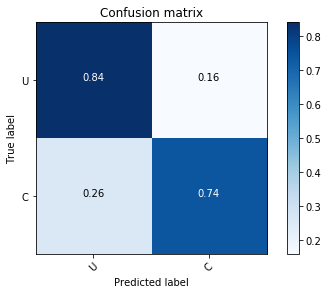

In [37]:
cm = confusion_matrix(label, pred)
plot_confusion_matrix(cm, classes=['U', 'C'], normalize=True)
plt.show()

In [44]:
torch.cuda.device_count()

2